In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def beamforming_vec(h0, h1):

    C0 = np.linalg.norm(h0)**2
    C1 = np.linalg.norm(h1)**2
    # rho = np.conj(h0.T) @ h1 / np.sqrt(C1 * C0)
    rho = np.conj(h1.T) @ h0 / np.sqrt(C1 * C0)
    alpha0 = 1 / (np.sqrt(1 - np.abs(rho)**2) * np.sqrt(C0))
    alpha1 = -rho / (np.sqrt(1 - np.abs(rho)**2) * np.sqrt(C1))
    w = alpha0 * h0 + alpha1 * h1

    return w, rho

In [3]:
EkT = -174    # Noise energy in dBm/Hz, antenna temperature for vsat: 290K
B = 100e6
Tx_power_dbm = 30 # dbm
Tx_power = 10 ** ((Tx_power_dbm - 30) / 10)

NF = 7  # Noise figure in dB
NF_vsat = 3
NF_bs = 2
# reference signal duration
preamble_time = 20e-6 
N0_vsat =  10 ** ((EkT + 10 * np.log10(B) + NF_vsat - 30) / 10)

# For channel estimation interference distribution, h_hat = h + CN~(0, N0/(Tx_power*time))
N0_sigma =  10 ** ((EkT+NF_bs - 30) / 10) /Tx_power/preamble_time


print(N0_vsat)

7.943282347242822e-13


In [4]:
dsep = 0.5  # Antenna separation in wavelengths

theta0 = 0  # Angle to RX0
theta1 = 15
theta0_rad = theta0 * np.pi / 180
theta1_rad = theta1 * np.pi / 180


ntx_num = np.array([16,32,48,64])
ntx_len = len(ntx_num)
simu_num = 1000 # tota; runing times
gamma_num = 1000
gamma_h1 = np.logspace(-8, -3, gamma_num) # adjustment to h1



inr = np.zeros((ntx_len,simu_num,gamma_num  ))
G_i = np.zeros((ntx_len,simu_num,gamma_num  ))
gamma_i_r = np.zeros((ntx_len,simu_num,gamma_num  ))
gamma_i_r2 = np.zeros((ntx_len,simu_num,gamma_num  ))


In [5]:

for ntxn, ntx in enumerate(ntx_num):

    phase0 = 2 * np.pi * np.arange(ntx) * dsep * np.cos(theta0_rad)
    phase1 = 2 * np.pi * np.arange(ntx) * dsep * np.cos(theta1_rad)
    h0 = np.exp(1j * phase0).reshape(-1,1)/np.sqrt(ntx)
    h_i = np.exp(1j * phase1).reshape(-1,1)/np.sqrt(ntx)
    for g, gamma in enumerate(gamma_h1):

 
        for n in range (simu_num):

            G_i[ntxn,n,g] = np.linalg.norm(gamma*h_i)**2  /ntx
            gamma_i_r[ntxn,n,g] =  Tx_power*preamble_time*G_i[ntxn,n,g]/N0_vsat
            gamma_i_r2[ntxn,n,g] =  G_i[ntxn,n,g]/N0_sigma

            noise = np.sqrt(N0_sigma/2)  * (np.random.randn(*h_i.shape) + 1j * np.random.randn(*h_i.shape))
            h_i_hat = gamma*h_i + noise 
            [w_t,rho_hat] = beamforming_vec(h0, h_i_hat)
            
            inr[ntxn,n,g] = (np.abs(np.conj(w_t.T) @ (gamma*h_i))**2)*Tx_power / N0_vsat    


/tmp/ipykernel_34937/455419005.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inr[ntxn,n,g] = (np.abs(np.conj(w_t.T) @ (gamma*h_i))**2)*Tx_power / N0_vsat


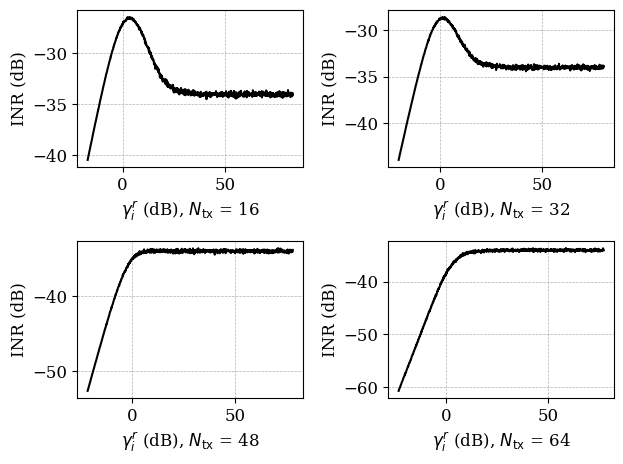

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 12,
    "legend.fontsize": 10,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

for n, ntx in enumerate(ntx_num):
    mean_gamma_i = np.mean(gamma_i_r[n,:,:], axis=0)
    mean_gamma_i2 = np.mean(gamma_i_r2[n,:,:], axis=0)
    mean_INR = 10*np.log10(np.mean(inr[n,:,:], axis=0))

    plt.subplot(2, 2, n+1)
    # plt.plot(10 * np.log10(gamma_h1), mean_INR, color='black')
    plt.plot(10 * np.log10(mean_gamma_i2), mean_INR, color='black')
    # plt.xlabel(f'$h_i$ (dB), $N_{{tx}}$ = {ntx}', fontsize=12)
    plt.xlabel(f'$\\gamma_i^r$ (dB), $N_{{\\mathrm{{tx}}}}$ = {ntx}', fontsize=12)
    plt.ylabel('INR (dB)', fontsize=12)
    # plt.xlim(-100, 0)
    # plt.ylim(-100, -20)
    # plt.xticks([-100, -50, 0])  
    # plt.yticks([-100, -60, -20]) 
    plt.grid(True, linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.savefig("ResultPlot/single_vic_inr_h3.pdf", format="pdf", bbox_inches="tight")
plt.savefig("ResultPlot/single_vic_inr_h3.png", format="png", bbox_inches="tight", dpi=300)
plt.show()
